                                                                            Luis Ramirez Camargo, June 2020

# Calculate accuracy indicators for PV output calculated with ERA5-land and MERRA 2 Data  

This notebook uses the outputs from the notebook clean_measured_pv_data_installations_chile to evaluate the accuracy of the outputs from  the notebook pv_output_from_ERA5_land_and_merra2. The accuracy is assessed using the pearsons coorelation coeficient, the Mean Biased Error (MBE), the root mean square error (rmse). 


## 1) import the libraries and data

In [3]:
import os
import itertools
import xarray as xr
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import glob
from tkinter import Tcl
import gc
import scipy as sp
import scipy.stats
import seaborn as sns
from pathlib import Path

## Import the capacity factors of the meassured data

In [4]:
reference = pd.read_csv(Path('intermediate_results/time_series_PV_sen_chile_capacity_factors.csv'), index_col=0, parse_dates=True)      

## 3) Import the capacity factors of the PV output calculated with ERA5-land data and MERRA2-data 

In [9]:
#modify the calculated data sets time series to match chilean summer time
#this cannot be performed automatically since the dailight summer time in chile changes from year to year
def summer_time_chile(cf_file):
    cf_utc = pd.read_csv(cf_file, index_col=0, parse_dates=True)
    cf_ut_st_2014 = cf_utc["2014-04-27":"2014-09-07"].shift(periods=-1).copy()
    cf_ut_st_2016 = cf_utc["2016-05-15":"2016-08-14"].shift(periods=-1).copy()
    cf_ut_st_2017 = cf_utc["2017-05-14":"2017-08-14"].shift(periods=-1).copy()
    cf_ut_st_2018 = cf_utc["2018-05-13":"2018-08-12"].shift(periods=-1).copy()
    cf_utc_st = cf_utc.copy()
    cf_utc_st.loc["2014-04-27":"2014-09-07"] = cf_ut_st_2014
    cf_utc_st.loc["2016-05-15":"2016-08-14"] = cf_ut_st_2016 
    cf_utc_st.loc["2017-05-14":"2017-08-14"] = cf_ut_st_2017
    cf_utc_st.loc["2018-05-13":"2018-08-12"] = cf_ut_st_2018
    return cf_utc_st

In [17]:
era5l_optimal = summer_time_chile(Path('intermediate_results/timeseries_capacity_factors_pv_optimal_era5l.csv'))
merra2_optimal = summer_time_chile(Path('intermediate_results/timeseries_capacity_factors_pv_optimal_merra2.csv'))
era5l_tracking = summer_time_chile(Path('intermediate_results/timeseries_capacity_factors_pv_tracking_era5l.csv'))
merra2_tracking = summer_time_chile(Path('intermediate_results/timeseries_capacity_factors_pv_tracking_merra2.csv'))

## 4) Indicators calculation for the validation ERA5-land

In [130]:
#there are 34 installations with objects, 
#long period of test before going fully online, long periods of missing values after commisioning day 
installations_with_artefacts = ["BELLAVISTA", "CARRERA PINTO ETAPA I",
                                           "CHANARES", "CONEJO SOLAR",
                                           "CORDILLERILLA","EL DIVISADERO",
                                           "FV BOLERO", "LAS TURCAS",
                                           "LOS PUQUIOS", "LUZ DEL NORTE",
                                           "PAMPA SOLAR NORTE", "PARQUE SOLAR CUZ CUZ",
                                           "PARQUE SOLAR FINIS TERRAE", "PARQUE SOLAR PAMPA CAMARONES",
                                           "PFV LAGUNILLA", "PFV LOS LOROS",
                                           "PLANTA PV CERRO DOMINADOR", "PMGD PICA PILOT",
                                           "PV SALVADOR", "QUILAPILUN",
                                           "SDGX01", "SOLAR ANTAY",
                                           "SOLAR DIEGO DE ALMAGRO", "SOLAR EL AGUILA I",
                                           "SOLAR EL ROMERO", "SOLAR ESPERANZA",
                                           "SOLAR HORMIGA", "SOLAR JAVIERA",
                                           "SOLAR LA SILLA", "SOLAR LAS TERRAZAS",
                                           "SOLAR LLANO DE LLAMPOS", "SOLAR SAN ANDRES",
                                           "SOLAR TECHOS ALTAMIRA", "TAMBO REAL"]
#Installations with other set up
installations_no_optimal = ["PUERTO SECO SOLAR", "URIBE SOLAR",
                               "ANDES SOLAR", "LA CHAPEANA","LA QUINTA SOLAR",
                                "PILOTO SOLAR CARDONES", "SAN FRANCISCO SOLAR",
                                "SANTA JULIA","MARIA ELENA FV","LALACKAMA",
                                "LALACKAMA 2","LAS ARAUCARIAS","SOLAR CHUCHINI",
                                "SOLAR JAMA 1", "SOLAR JAMA 2","TILTIL SOLAR","VALLE DE LA LUNA II"]

In [150]:
def validate_pv_output_all(reference_values_df,calculated_values_df, name_file_to_store):
    '''calculate the accuracy indicators for each plant where the reference data set is not empty'''
    indicators = pd.DataFrame(columns=("pearson_h",
                                       "mbe_h",
                                       "rmse_h",
                                       "observations",
                                       "pearson_d",
                                       "mbe_d",
                                       "rmse_d",
                                       "days",
                                       "pearson_m",
                                       "mbe_m",
                                       "rmse_m",
                                       "months"), index=calculated_values_df.columns)
    for plant in calculated_values_df.columns:
        if np.sum(reference_values_df[plant]["2014":"2018"]) > 0:
            #print(plant)
            comp_pre = pd.DataFrame(columns=("new","reference"), index=calculated_values_df.index)
            #print(np.array(calculated_values_df.index).size)
            comp_pre["new"] = np.array(calculated_values_df[plant]["2014":"2018"]).copy()
            #print(np.array(reference_values_df[plant]["2014":"2018"].copy()).size)
            #print(reference_values_df[plant]["2014-01-01"])
            comp_pre.loc[3:,"reference"] = reference_values_df[plant][0:-5].values
            #print(comp_pre)
            comp = comp_pre.dropna(axis=0).copy()
            #print(comp)
            new = comp["new"]
            reference = comp["reference"]
            pearson = sp.stats.pearsonr(reference.astype(float), new.astype(float))
            indicators.loc[plant]["pearson_h"] = pearson[0]
            indicators.loc[plant]["mbe_h"] = (np.sum(new-reference))/np.sum(reference.size)
            observations = comp.size/comp.columns.size
            indicators.loc[plant]["observations"] = observations
            indicators.loc[plant]["rmse_h"] = np.sqrt((np.sum((new-reference)**2))/(observations))
            #indicators.loc[plant]["rmse_r_h"] = np.sqrt((np.sum((new-reference)**2))/observations)/(np.sum(reference/observations))
            new_avg_day = round(new.resample('D').mean(),4).dropna().copy()
            days = new_avg_day.size
            indicators.loc[plant]["days"] = days
            reference_avg_day = round(reference.astype(float).resample('D').mean(),4).dropna().copy()
            pearson_days = sp.stats.pearsonr(reference_avg_day.astype(float), new_avg_day.astype(float))
            indicators.loc[plant]["pearson_d"] = pearson_days[0]
            indicators.loc[plant]["mbe_d"] = (np.sum(new_avg_day-reference_avg_day))/np.sum(reference_avg_day.size)
            indicators.loc[plant]["rmse_d"] = np.sqrt((np.sum((new_avg_day-reference_avg_day)**2))/(np.sum(reference_avg_day.size)))
            new_avg_month = round(new.resample('M').mean(),4).dropna().copy()
            months = new_avg_month.size 
            if months > 1:
                reference_avg_month = round(reference.astype(float).resample('M').mean(),4).dropna().copy()
                pearson_months = sp.stats.pearsonr(reference_avg_month.astype(float), new_avg_month.astype(float))
                indicators.loc[plant]["pearson_m"] = pearson_months[0]
                indicators.loc[plant]["mbe_m"] = (np.sum(new_avg_month-reference_avg_month))/np.sum(reference_avg_month.size)
                indicators.loc[plant]["rmse_m"] = np.sqrt((np.sum((new_avg_month-reference_avg_month)**2))/(np.sum(reference_avg_month.size)))
                indicators.loc[plant]["months"] = months
    #drop all installations where no meassured data is available
    indicators = indicators.dropna().copy()
    #drop all installations where less than 12 months of data are available
    minimum_months = 12
    indicators = indicators.loc[indicators["months"] > minimum_months].drop(["observations",
                                                                              "days",
                                                                              "months"], axis=1).copy()
    indicators.to_csv(name_file_to_store)
    return indicators

In [151]:
indicators_era5l_optimal = validate_pv_output_all(reference,
                                                  era5l_optimal,
                                                  Path('intermediate_results/indicators_era5l_optimal.csv'))

In [162]:
indicators_era5l_tracking = validate_pv_output_all(reference,
                                                  era5l_tracking,
                                                  Path('intermediate_results/indicators_era5l_tracking.csv'))

In [152]:
indicators_merra2_optimal = validate_pv_output_all(reference,
                                                  merra2_optimal,
                                                  Path('intermediate_results/indicators_merra2_optimal.csv'))

In [153]:
results_era5l_optimal = pd.read_csv(Path('intermediate_results/indicators_era5l_optimal.csv'), index_col=0)
results_era5l_optimal_23 = results_era5l_optimal.drop(installations_with_artefacts)
#selected results 3 excludes installations 
results_era5l_optimal_6 = results_era5l_optimal_23.drop(installations_no_optimal)

In [163]:
results_era5l_tracking = pd.read_csv(Path('intermediate_results/indicators_era5l_tracking.csv'), index_col=0)
results_era5l_tracking_23 = results_era5l_tracking.drop(installations_with_artefacts)
#selected results 3 excludes installations 
results_era5l_tracking_6 = results_era5l_tracking_23.drop(installations_no_optimal)

In [154]:
results_merra2_optimal = pd.read_csv(Path('intermediate_results/indicators_merra2_optimal.csv'), index_col=0)
results_merra2_optimal_23 = results_era5l_optimal.drop(installations_with_artefacts)
#selected results 3 excludes installations 
results_merra2_optimal_6 = results_era5l_optimal_23.drop(installations_no_optimal)

In [155]:
def summary_plots(set_to_plot):
    boxplot = set_to_plot.boxplot(figsize=(20,6))
    set_to_plot.hist(figsize=(20,12))
    set_to_plot.shape

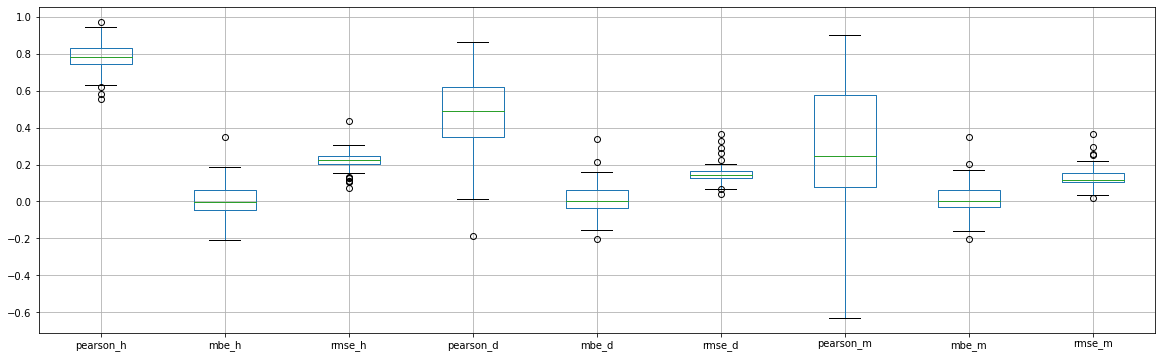

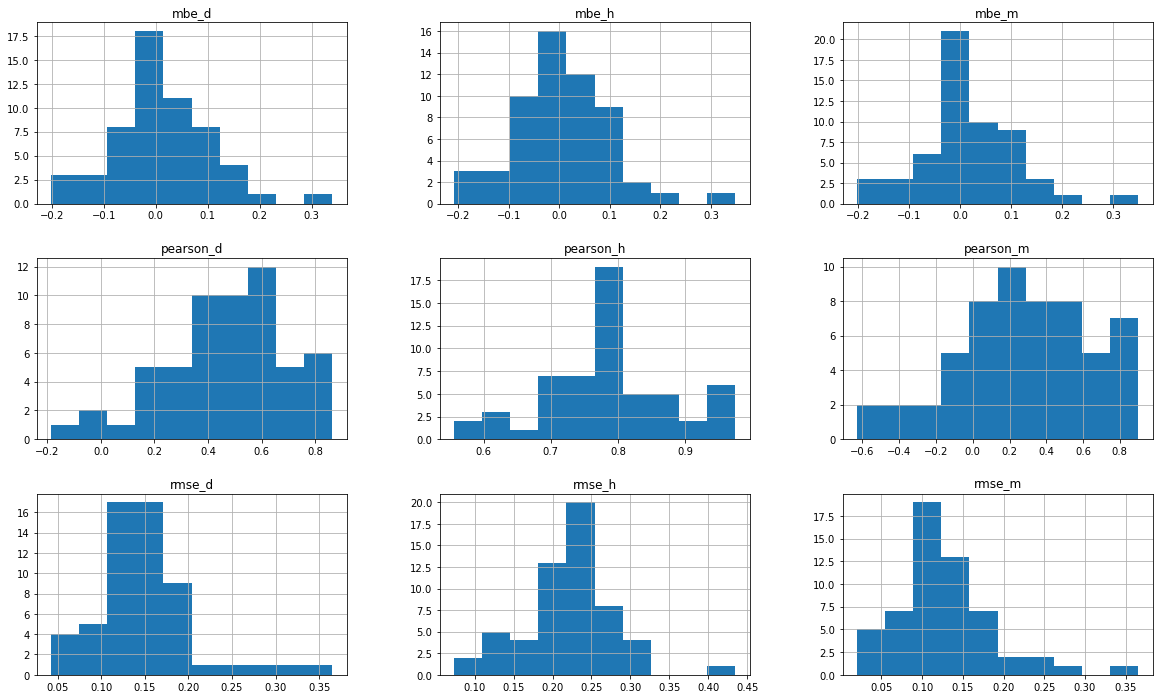

In [156]:
summary_plots(results_era5l_optimal)

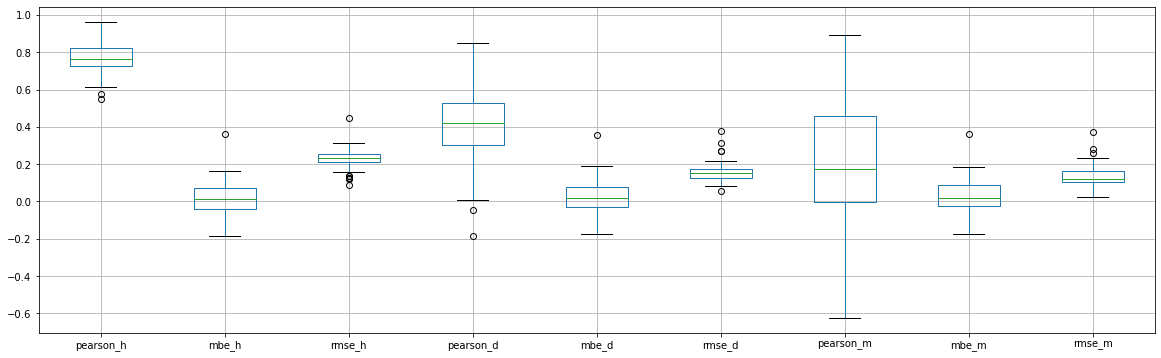

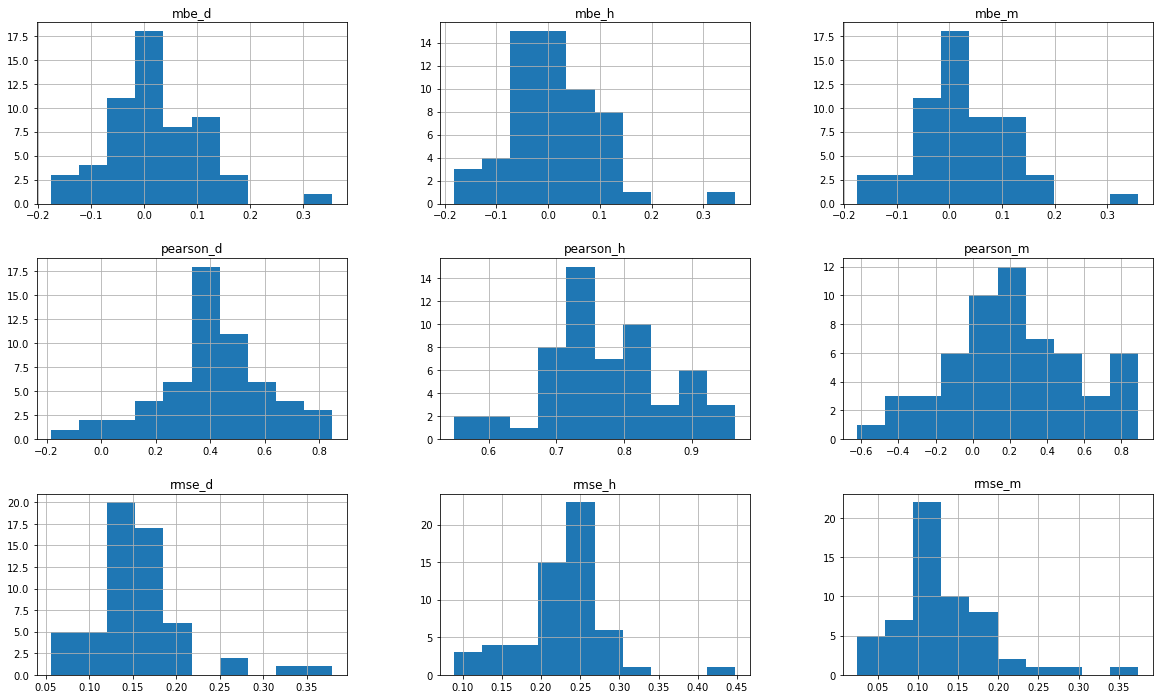

In [157]:
summary_plots(results_merra2_optimal)

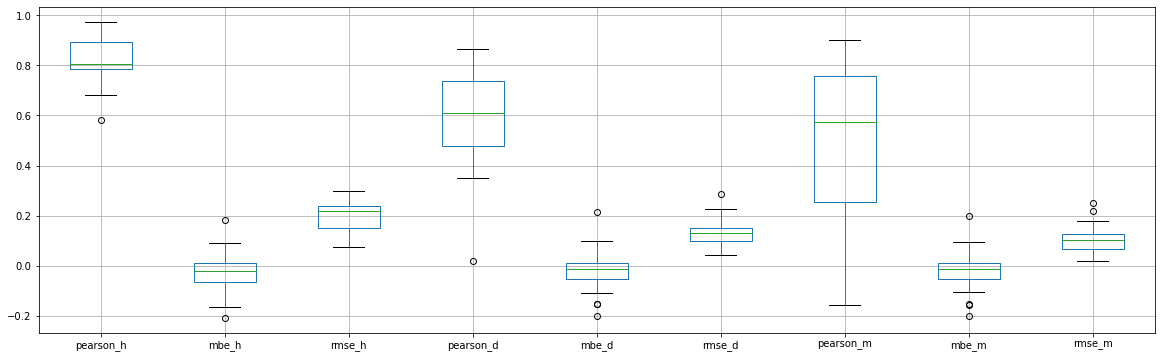

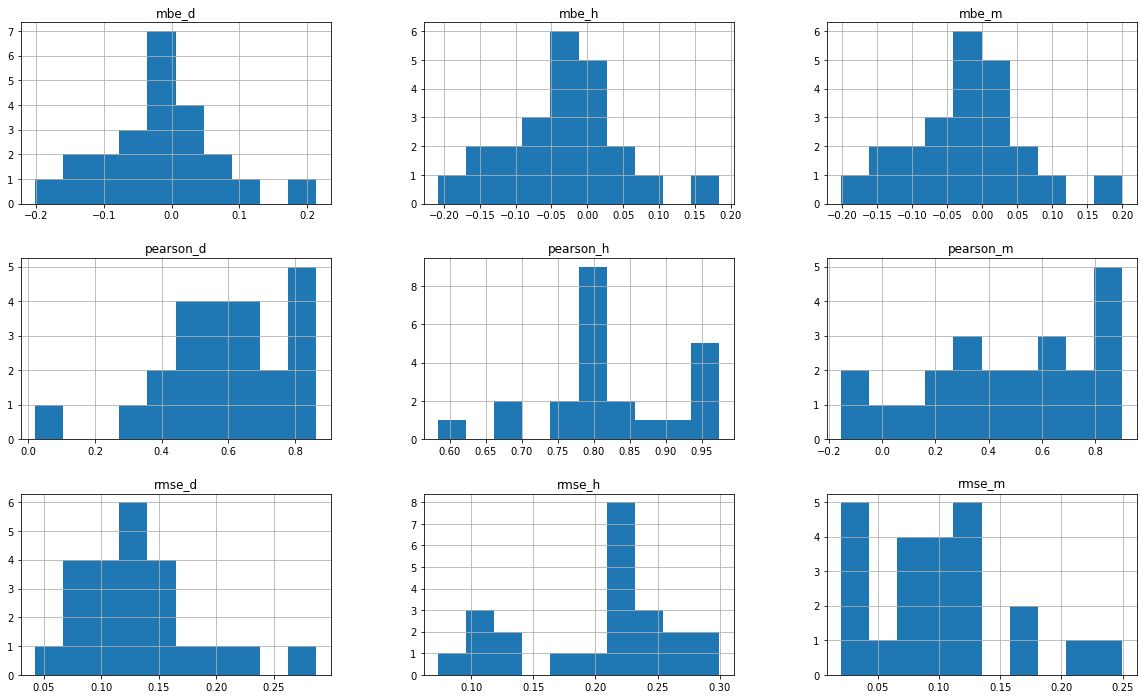

In [159]:
summary_plots(results_era5l_optimal_23)

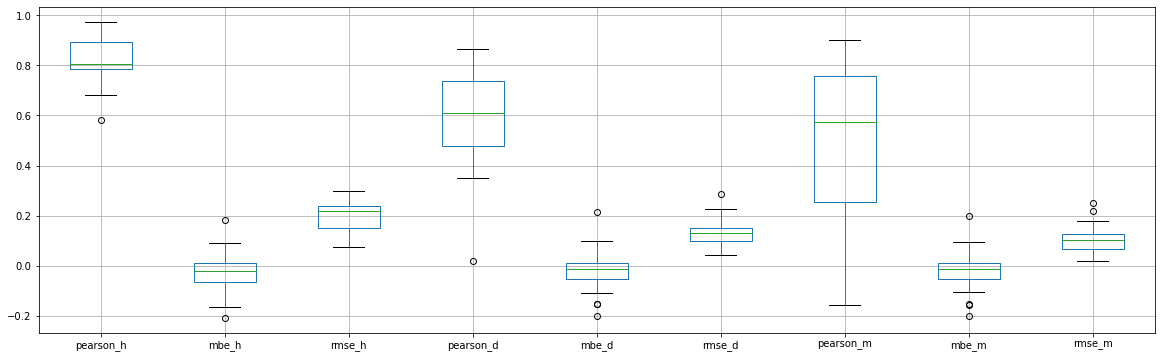

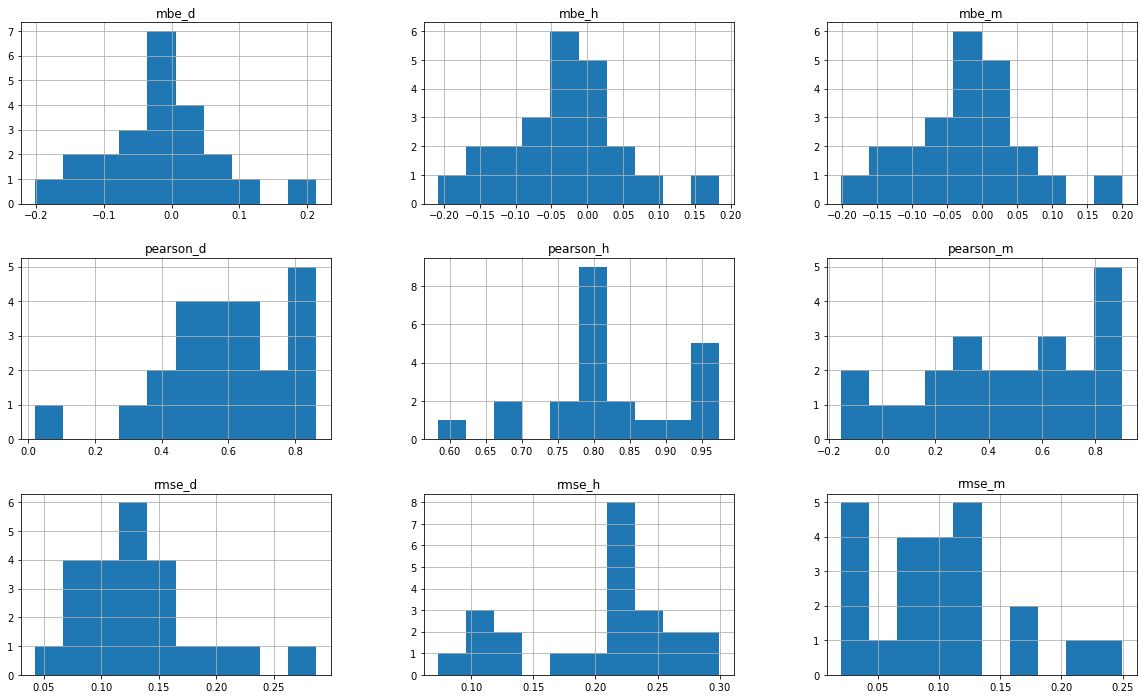

In [158]:
summary_plots(results_merra2_optimal_23)

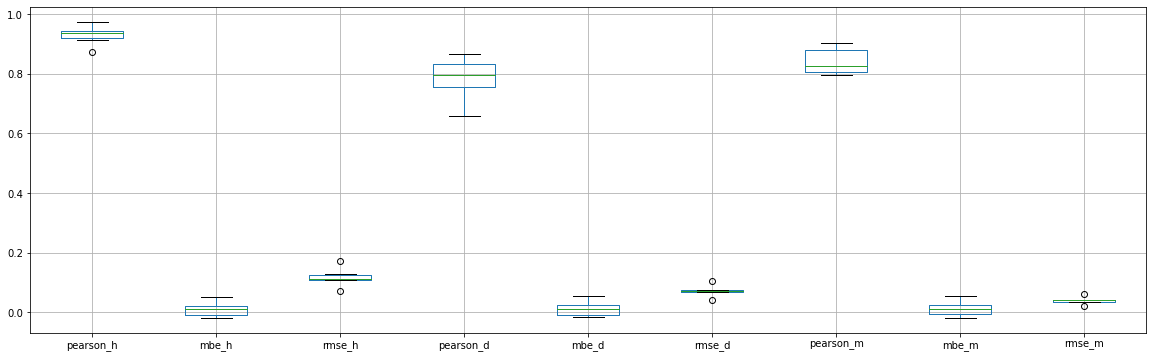

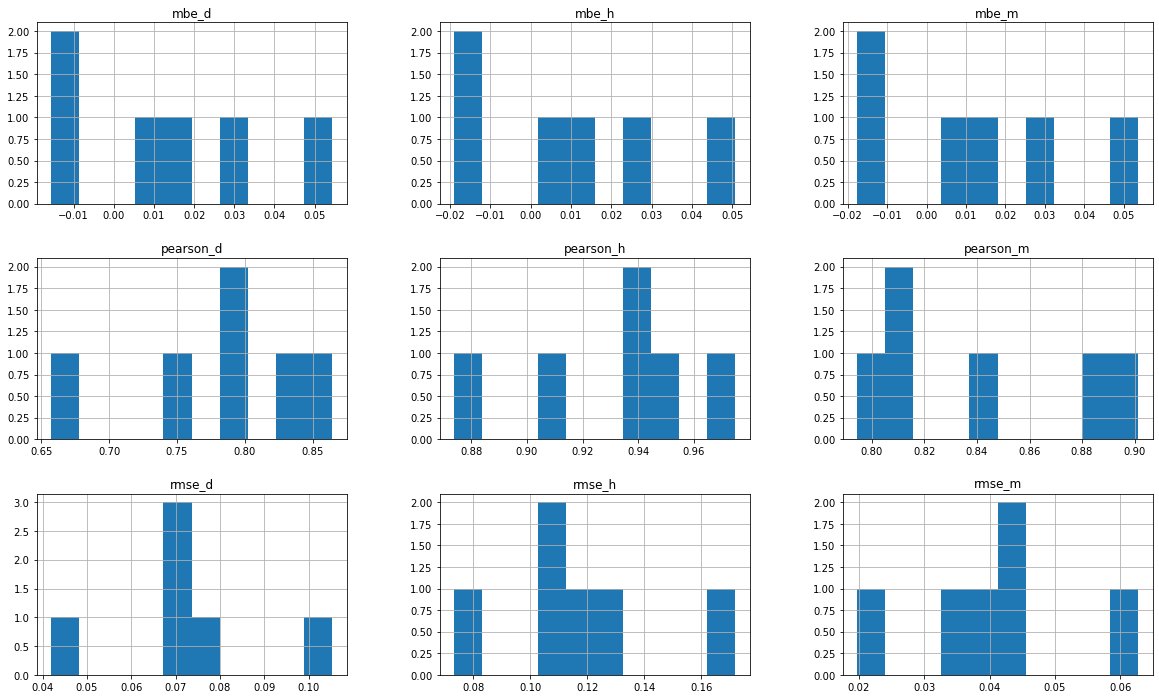

In [160]:
summary_plots(results_era5l_optimal_6)

In [16]:
#export the indicators of the 57 installations
#selected_results.to_csv("comparison_PV_ERA5land_rn_chile/indicators_era5land.csv")

## Individual plant testing

In [ ]:
#for plant in selected_results.index:
    print(plant)
    print(selected_results.loc[plant])
    fig = plt.figure(figsize=(20,6))
    plt.plot(calculated[plant])
    plt.plot(rn[plant])
    plt.plot(reference_pre2[plant])
    plt.show()

In [ ]:
plt.plot(calculated[plant])
plt.plot(rn[plant])
reference_pre2[plant].plot()
pd.to_datetime(rn.index)
#print(calculated.index)
#print(rn.index)

In [ ]:
results.loc["SOLAR LLANO DE LLAMPOS"]

In [90]:
start = "2014-01-01"
ende = "2018-12-31"
#plant = "LALACKAMA"
#plant = "LAS MOLLACAS"
#plant = "PILOTO SOLAR CARDONES"
#plant = "SOLAR TECHOS ALTAMIRA"
#plant = "LUNA DEL NORTE"
plant = "BELLAVISTA"
#plant = "SOL DEL NORTE"
comp_pre = pd.DataFrame(columns=("calculated","RN","reference"), index=calculated.index)
comp_pre["calculated"] = np.array(calculated[plant]["2014":"2018"].copy())
#comp_pre["reference"] = np.array(reference_pre2[plant]["2014":"2018"].copy())
#comp_pre["RN"] = np.array(rn[plant]["2014":"2018"].copy())
#comp = comp_pre[:][start:ende]
#comp = comp_pre.dropna().copy()
#comp.plot.area(figsize=(20,6), stacked=False)
#comp_pre["reference"].plot()
#reference_pre2[plant].plot()

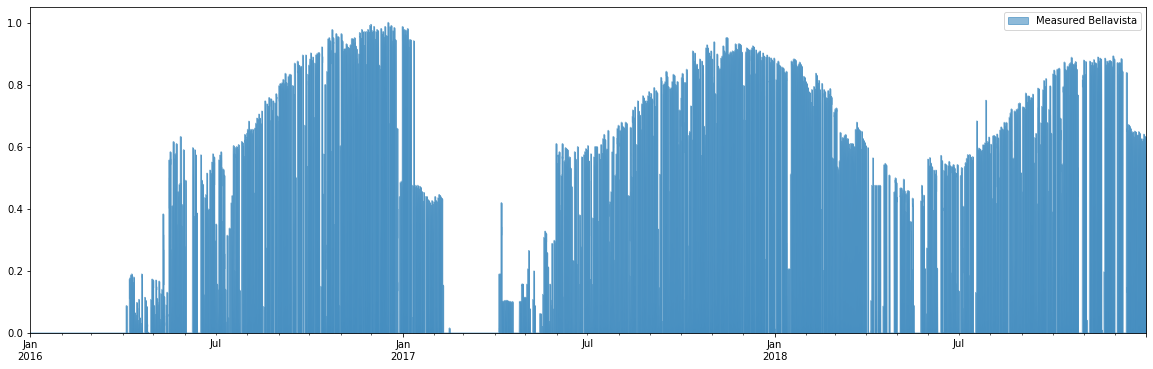

In [277]:
#artifacts example
start = "2016-01-01"
ende = "2018-12-31"
plant = "BELLAVISTA"
comp_pre = pd.DataFrame(index=reference_pre2.index)
comp_pre["Measured Bellavista"] = np.array(reference_pre2[plant].copy())
comp = comp_pre[:][start:ende]
comp.plot.area(figsize=(20,6), stacked=False)

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


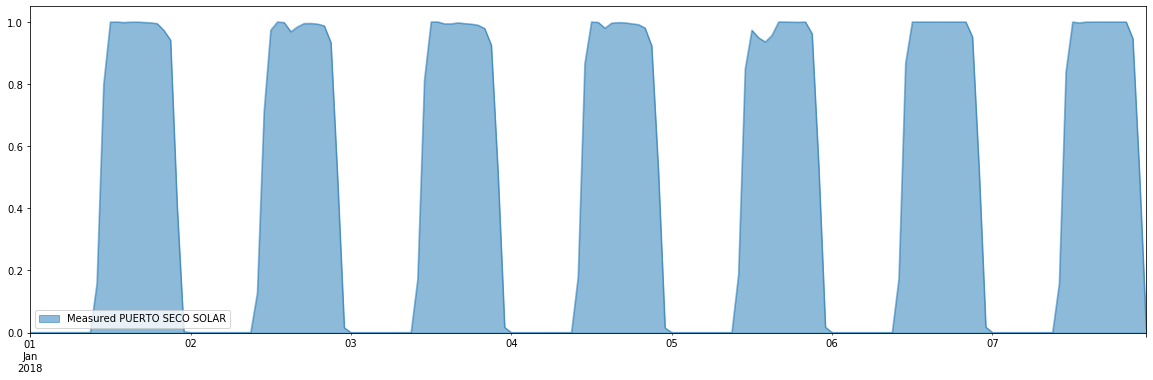

In [17]:
#tracker/inverter example
start = "2018-01-01"
ende = "2018-01-07"
plant = "PUERTO SECO SOLAR"
comp_pre = pd.DataFrame(index=calculated.index)
comp_pre["Measured PUERTO SECO SOLAR"] = reference_pre2[plant]["2014":"2018"].copy()
#comp_pre["PUERTO SECO SOLAR RN"] = rn[plant]["2014":"2018"].copy()
#comp_pre["PUERTO SECO SOLAR calculated"] = calculated[plant]["2014":"2018"].copy()
comp = comp_pre[:][start:ende]
comp.plot.area(figsize=(20,6), stacked=False)

## Deseasonalize the timeseries of the plants with the same assumptions

In [29]:
#create a data frame to store the clearsky values for each location
cs_df = pd.DataFrame(columns=results_rn3.index, index=pd.to_datetime(date_range))


In [37]:
#create a data frame to store the clearsky values for all locations
cs_all_df = pd.DataFrame(columns=results_pre.index, index=pd.to_datetime(date_range))

In [38]:
for location in results_pre.index:
    lat = installations_chile.loc[location]['latitude']
    lon = installations_chile.loc[location]['longitude']-360
    print(str(location)+" "+str(lat)+" "+str(lon))
    tus = Location(lat, lon, 'Chile/Continental')
    cs = tus.get_clearsky(pd.to_datetime(date_range))
    cs_all_df[location] = cs.ghi/np.max(cs.ghi)

ALTURAS DE OVALLE -30.55262143331524 -71.23970369796871
AMPARO DEL SOL -30.612201745556767 -71.32852091728893
ANDES SOLAR -24.001285936016476 -68.57214924473493
BELLAVISTA -31.666267724658596 -71.2209422807212
CABILSOL -32.46644957504466 -71.10317730147608
CALAMA SOLAR 1 -22.44421997237862 -68.87014116006242
CARRERA PINTO ETAPA I -27.00423631205058 -69.86703741596284
CHANARES -26.37305845667075 -70.08012924543272
CHANCON -34.09127389482801 -70.82221469634203
CHIMBARONGO -34.823292197114455 -70.96819807819782
CONEJO SOLAR -25.504103214818855 -70.16290331279362
CORDILLERILLA -35.16270112191474 -71.1323198303935
DON EUGENIO -34.265019791032415 -71.38614422387406
EL BOCO -32.85510111067465 -71.24489356987033
EL CERNICALO 1 -36.42841895915341 -72.37291504177335
EL CERNICALO 2 -36.42841895915341 -72.37291504177335
EL DIVISADERO -30.84574463612748 -71.12747300362042
EL PILPEN -33.55887577770755 -71.2427674678143
EL PITIO -35.97579502292846 -71.69565261088007
EL ROBLE -34.035829531796075 -71.3

In [42]:
cs_all_df.to_csv('clear_sky_normalized_88_installations.csv')

In [43]:
#cs_all_df

In [44]:
#create a data frame to store the clearsky values in w/m2 for all locations
cs_all_in_w_df = pd.DataFrame(columns=results_pre.index, index=pd.to_datetime(date_range))

In [45]:
for location in results_pre.index:
    lat = installations_chile.loc[location]['latitude']
    lon = installations_chile.loc[location]['longitude']-360
    print(str(location)+" "+str(lat)+" "+str(lon))
    tus = Location(lat, lon, 'Chile/Continental')
    cs = tus.get_clearsky(pd.to_datetime(date_range))
    cs_all_in_w_df[location] = cs.ghi

ALTURAS DE OVALLE -30.55262143331524 -71.23970369796871
AMPARO DEL SOL -30.612201745556767 -71.32852091728893
ANDES SOLAR -24.001285936016476 -68.57214924473493
BELLAVISTA -31.666267724658596 -71.2209422807212
CABILSOL -32.46644957504466 -71.10317730147608
CALAMA SOLAR 1 -22.44421997237862 -68.87014116006242
CARRERA PINTO ETAPA I -27.00423631205058 -69.86703741596284
CHANARES -26.37305845667075 -70.08012924543272
CHANCON -34.09127389482801 -70.82221469634203
CHIMBARONGO -34.823292197114455 -70.96819807819782
CONEJO SOLAR -25.504103214818855 -70.16290331279362
CORDILLERILLA -35.16270112191474 -71.1323198303935
DON EUGENIO -34.265019791032415 -71.38614422387406
EL BOCO -32.85510111067465 -71.24489356987033
EL CERNICALO 1 -36.42841895915341 -72.37291504177335
EL CERNICALO 2 -36.42841895915341 -72.37291504177335
EL DIVISADERO -30.84574463612748 -71.12747300362042
EL PILPEN -33.55887577770755 -71.2427674678143
EL PITIO -35.97579502292846 -71.69565261088007
EL ROBLE -34.035829531796075 -71.3

In [46]:
cs_all_in_w_df.to_csv('clear_sky_88_installations.csv')

In [30]:
for location in results_rn3.index:
    lat = installations_chile.loc[location]['latitude']
    lon = installations_chile.loc[location]['longitude']-360
    print(str(location)+" "+str(lat)+" "+str(lon))
    tus = Location(lat, lon, 'Chile/Continental')
    cs = tus.get_clearsky(pd.to_datetime(date_range))
    cs_df[location] = cs.ghi/np.max(cs.ghi)

LAS MOLLACAS -30.676327020803715 -71.2255644211649
LUNA DEL NORTE -30.040192044276893 -70.68000578333931
SOL DEL NORTE -30.04006352202994 -70.68370578967495
SOLAR PSF LOMAS COLORADAS -31.18638247016862 -71.02254980543262
SOLAR SANTA CECILIA -29.117177584831456 -70.91339171901228
SPS LA HUAYCA -20.45456065243675 -69.53401235824447


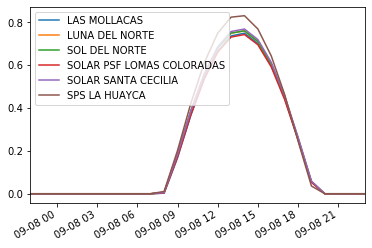

In [72]:
cs_df["2014-09-07 22:00" :"2014-09-08"].plot()

In [73]:
cs_pre = cs_df.tz_convert('UTC').copy()
cs_dst_2014 = cs_pre["2014-04-27":"2014-09-08 00:00"].shift(periods=-1).copy()
cs_dst_2016 = cs_pre["2016-05-15":"2016-08-15 00:00"].shift(periods=-1).copy()
cs_dst_2017 = cs_pre["2017-05-14":"2017-08-15 00:00"].shift(periods=-1).copy()
cs_dst_2018 = cs_pre["2018-05-13":"2018-08-13 00:00"].shift(periods=-1).copy()

cs = cs_pre.copy()
cs.loc["2014-04-27":"2014-09-08 00:00"] = cs_dst_2014
cs.loc["2016-05-15":"2016-08-15 00:00"] = cs_dst_2016 
cs.loc["2017-05-14":"2017-08-15 00:00"] = cs_dst_2017
cs.loc["2018-05-13":"2018-08-13 00:00"] = cs_dst_2018

In [74]:
#create data frames for the deseasonalized time series
des_ref = pd.DataFrame(columns=results_rn3.index, index=reference_pre2.index)
des_era5 = pd.DataFrame(columns=results_rn3.index, index=reference_pre2.index)
des_rn = pd.DataFrame(columns=results_rn3.index, index=reference_pre2.index)
#calculate the deseasonalized time series
for plant in results_rn3.index:
    des_ref[plant] = reference_pre2[plant] - cs[plant]
    des_era5[plant] = calculated[plant] - cs[plant]
    des_rn[plant] = rn[plant] - cs[plant]

In [75]:
#calculate the indicators for the desasonalized time series
indicators_cs = pd.DataFrame(columns=("pearson_h_era5","pearson_h_rn",
                                   "mbe_h_era5","mbe_h_rn",
                                   "rmse_h_era5","rmse_h_rn",
                                   "pearson_d_era5", "pearson_d_rn",
                                   "mbe_d_era5", "mbe_d_rn",
                                   "rmse_d_era5", "rmse_d_rn",
                                   "pearson_m_era5", "pearson_m_rn",
                                   "mbe_m_era5", "mbe_m_rn",
                                   "rmse_m_era5", "rmse_m_rn"), index=results_rn3.index)
for plant in results_rn3.index:
    #print(plant)
    comp_pre = pd.DataFrame(columns=("era5","rn","reference"), index=rn.index)
    comp_pre["rn"] = des_rn[plant]["2014":"2018"].copy()
    comp_pre["era5"] = des_era5[plant]["2014":"2018"].copy()
    comp_pre["reference"] = des_ref[plant]["2014":"2018"].copy()
    comp = comp_pre.dropna().copy()
    rnin = comp["rn"]
    era5 = comp["era5"]
    reference = comp["reference"]
    #print(reference.size)
    #hourly indicators
    pearson_rn = sp.stats.pearsonr(reference.astype(float), rnin.astype(float))
    pearson_era5 = sp.stats.pearsonr(reference.astype(float), era5.astype(float))
    indicators_cs.loc[plant]["pearson_h_rn"] = pearson_rn[0]
    indicators_cs.loc[plant]["pearson_h_era5"] = pearson_era5[0]
    indicators_cs.loc[plant]["mbe_h_rn"] = (np.sum(rnin-reference))/np.sum(reference.size)
    indicators_cs.loc[plant]["mbe_h_era5"] = (np.sum(era5-reference))/np.sum(reference.size)
    indicators_cs.loc[plant]["rmse_h_rn"] = np.sqrt((np.sum((rnin-reference)**2))/(reference.size))
    indicators_cs.loc[plant]["rmse_h_era5"] = np.sqrt((np.sum((era5-reference)**2))/(reference.size))
    #daily indicators
    rn_avg_day = round(rnin.resample('D').mean(),4).dropna().copy()
    era5_avg_day = round(era5.resample('D').mean(),4).dropna().copy()
    reference_avg_day = round(reference.astype(float).resample('D').mean(),4).dropna().copy()
    days = reference_avg_day.size
    pearson_days_rn = sp.stats.pearsonr(reference_avg_day.astype(float), rn_avg_day.astype(float))
    pearson_days_era5 = sp.stats.pearsonr(reference_avg_day.astype(float), era5_avg_day.astype(float))
    indicators_cs.loc[plant]["pearson_d_era5"] = pearson_days_era5[0]
    indicators_cs.loc[plant]["pearson_d_rn"] = pearson_days_rn[0]
    indicators_cs.loc[plant]["mbe_d_era5"] = (np.sum(era5_avg_day-reference_avg_day))/days
    indicators_cs.loc[plant]["mbe_d_rn"] = (np.sum(rn_avg_day-reference_avg_day))/days
    indicators_cs.loc[plant]["rmse_d_era5"] = np.sqrt((np.sum((era5_avg_day-reference_avg_day)**2))/days)
    indicators_cs.loc[plant]["rmse_d_rn"] = np.sqrt((np.sum((rn_avg_day-reference_avg_day)**2))/days)
    #monthly indicators
    rn_avg_month = round(rnin.resample('M').mean(),4).dropna().copy()
    era5_avg_month = round(era5.resample('M').mean(),4).dropna().copy()
    months = new_avg_month.size
    reference_avg_month = round(reference.astype(float).resample('M').mean(),4).dropna().copy()
    pearson_months_rn = sp.stats.pearsonr(reference_avg_month.astype(float), rn_avg_month.astype(float))
    pearson_months_era5 = sp.stats.pearsonr(reference_avg_month.astype(float), era5_avg_month.astype(float))
    indicators_cs.loc[plant]["pearson_m_rn"] = pearson_months_rn[0]
    indicators_cs.loc[plant]["pearson_m_era5"] = pearson_months_era5[0]
    indicators_cs.loc[plant]["mbe_m_rn"] = (np.sum(rn_avg_month-reference_avg_month))/months
    indicators_cs.loc[plant]["rmse_m_rn"] = np.sqrt((np.sum((rn_avg_month-reference_avg_month)**2))/months)
    indicators_cs.loc[plant]["mbe_m_era5"] = (np.sum(era5_avg_month-reference_avg_month))/months
    indicators_cs.loc[plant]["rmse_m_era5"] = np.sqrt((np.sum((era5_avg_month-reference_avg_month)**2))/months)
    

In [76]:
print(indicators_cs)

                          pearson_h_era5 pearson_h_rn  mbe_h_era5    mbe_h_rn  \
LAS MOLLACAS                    0.525312     0.457872   0.0453172   0.0496285   
LUNA DEL NORTE                  0.780145     0.744199  -0.0211721   0.0502523   
SOL DEL NORTE                   0.780382     0.736594  -0.0245958   0.0467601   
SOLAR PSF LOMAS COLORADAS       0.787733     0.752433   0.0199562   0.0419148   
SOLAR SANTA CECILIA             0.731411     0.728974  0.00842654   0.0348447   
SPS LA HUAYCA                   0.847467     0.840099  0.00408702  0.00610597   

                          rmse_h_era5  rmse_h_rn pearson_d_era5 pearson_d_rn  \
LAS MOLLACAS                 0.170747   0.176665       0.728479     0.686079   
LUNA DEL NORTE               0.117383    0.12863       0.875529     0.820081   
SOL DEL NORTE                0.118496   0.129588       0.873816     0.810822   
SOLAR PSF LOMAS COLORADAS    0.115528   0.122536       0.903308      0.83846   
SOLAR SANTA CECILIA          0.1

In [77]:
indicators_cs.to_csv("indicators_cs_ERA5_land_and_rn.csv")

In [78]:
indicators_des = pd.read_csv("indicators_cs_ERA5_land_and_rn.csv", index_col=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ea5f63160>,
      dtype=object)

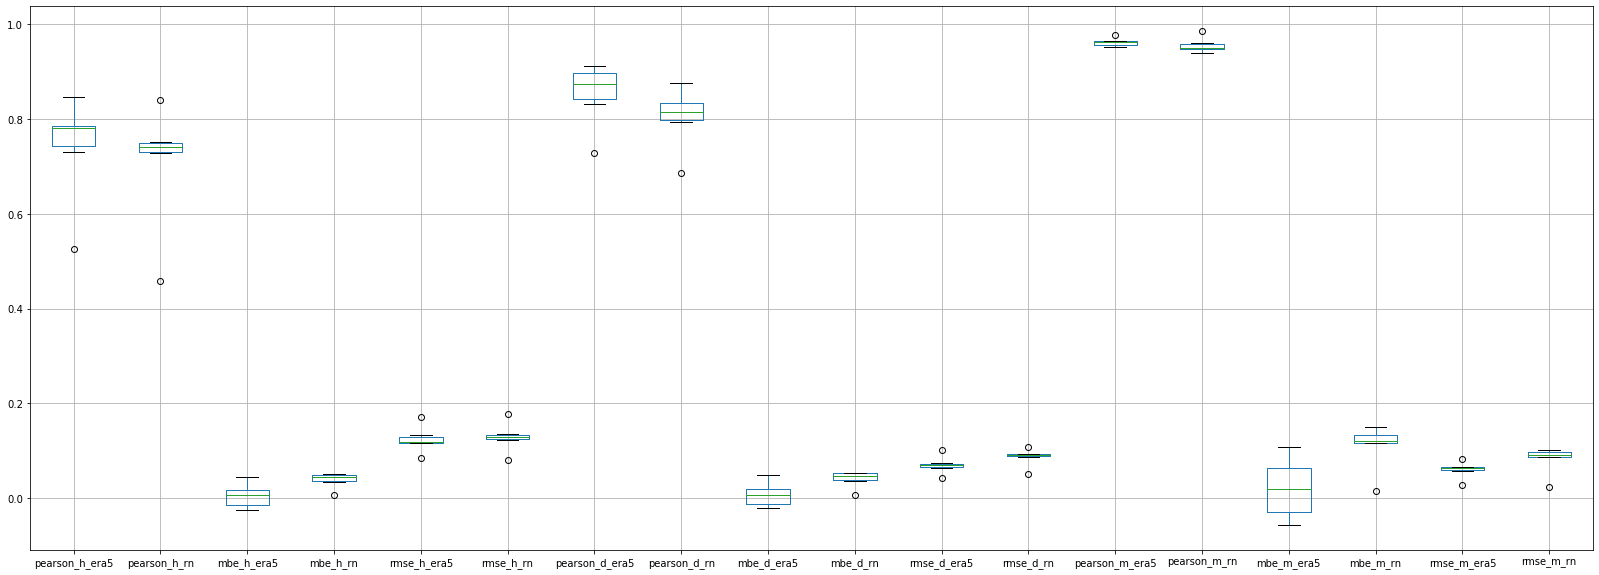

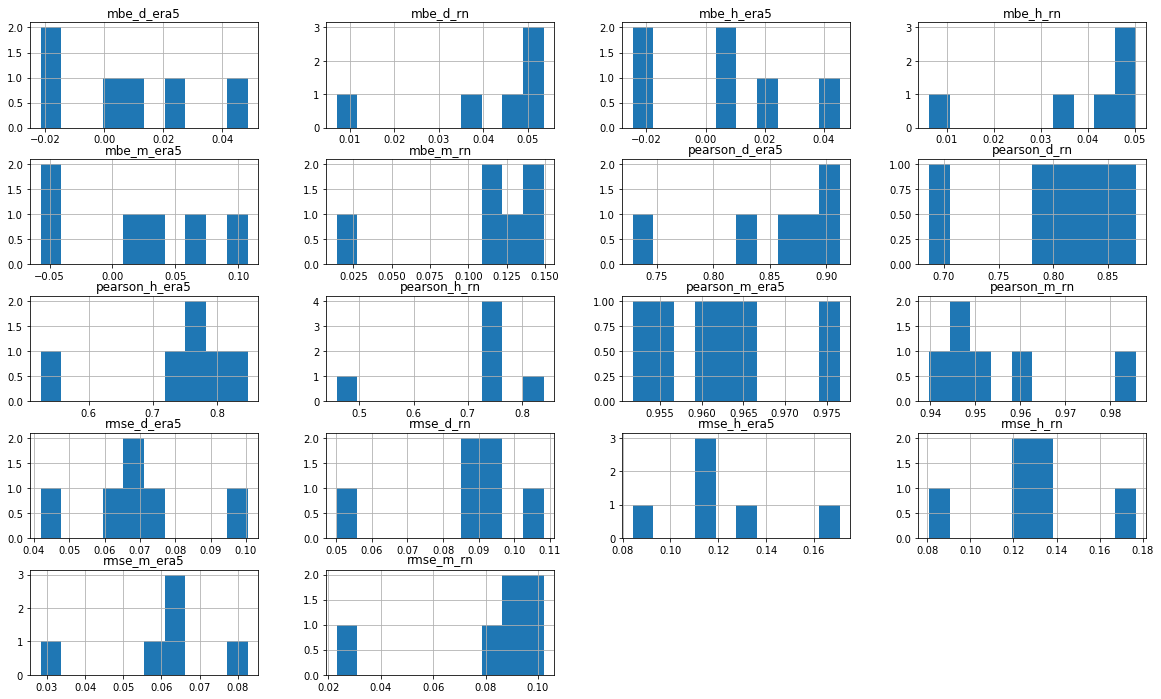

In [79]:
boxplot = indicators_des.boxplot(figsize=(28,10))
indicators_des.hist(figsize=(20,12))

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


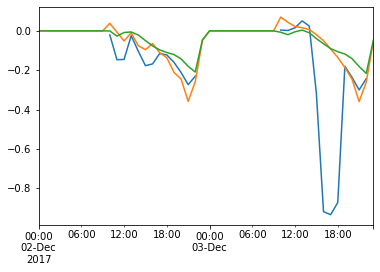

In [80]:
plant = "SOLAR SANTA CECILIA"
start = "2017-12-2"
end = "2017-12-3"
#cs[location][start:end].plot()
#calculated[plant][start:end].plot()
des_ref[plant][start:end].plot()
des_era5[plant][start:end].plot()
des_rn[plant][start:end].plot()

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


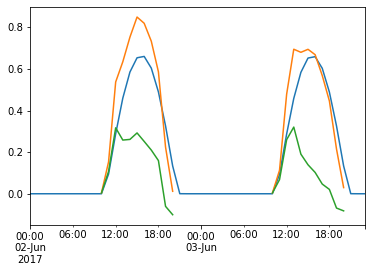

In [81]:
plant = "SOLAR SANTA CECILIA"
start = "2017-6-2"
end = "2017-6-3"
cs[location][start:end].plot()
reference_pre2[plant][start:end].plot()
des_ref[plant][start:end].plot()

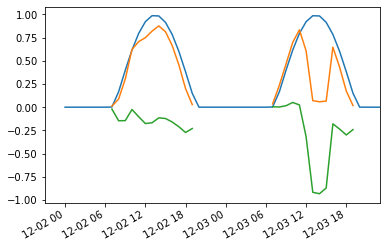

In [82]:
plant = "SOLAR SANTA CECILIA"
start = "2017-12-2"
end = "2017-12-3"
cs_df[location][start:end].plot()
reference_pre2[plant][start:end].plot()
des_ref[plant][start:end].plot()

## Additional tables

In [439]:
full_pv_set = installations_chile.loc[selected_results.index].copy()
full_pv_set['longitude'] = full_pv_set['longitude'].copy() - 360 
full_pv_set = full_pv_set.rename(columns={"size": "size_official_MW"})
full_pv_set = full_pv_set.drop(['end_time'], axis = 1).copy()

In [467]:
#adds information about the sets
full_pv_set['set'] = 'all'
for i in selected_results2.index:
    full_pv_set['set'][i]='s1'
    
for i in selected_results3.index:
    full_pv_set['set'][i]='s2'
#adds information about the first day with records
full_pv_set.loc[:,'first_record'] = 'empty'
for i in pv_reference.columns:
    test = pv_reference[i].dropna().copy()
    #print(test.index[0])
    full_pv_set.loc[i,'first_record'] = str(test.index[0])[:-15]
for i in full_pv_set.index:
    generation_raw1 = timeseries_installations_sen_raw[i].dropna().copy()
    #add estimated size in MW and total generation since first record
    if np.sum(generation_raw1) > 0:
        installation_size = (np.percentile(generation_raw1,99))
        outliers_threshold = installation_size * 1.1
        #transfrom the outlayers into nan
        generation_raw2 = timeseries_installations_sen[i].where(timeseries_installations_sen[i] < outliers_threshold, 
                                                                np.nan).copy()
        full_pv_set.loc[i,'size_estimated_MW'] = round(np.max(generation_raw2), 2)
        full_pv_set.loc[i,'total_generation_measured_GWh'] = round((np.sum(generation_raw2)/1000),2)
    #add to the table measured and calculated capacity factors
    ts_with_0 = pv_reference.loc[full_pv_set.loc[i, 'first_record']:,i].where(pv_reference.loc[full_pv_set.loc[i, 'first_record']:,i] > 0.0, 0.0).copy()
    full_pv_set.loc[i,'avg_CF_meassured'] = round(ts_with_0.mean(), 2)
    full_pv_set.loc[i,'avg_CF_era5_land'] = round(pv_era5land.loc[:,i].mean(), 2)
    full_pv_set.loc[i,'size_percentage_diff'] = round(((full_pv_set.loc[i,'size_estimated_MW'] -
                                                 full_pv_set.loc[i,'size_official_MW'])/
                                                       full_pv_set.loc[i,'size_official_MW'])*100, 2)
#modifies the order of the columns
#full_pv_set.loc[selected_results3.index,:]
#print(full_pv_set['size_percentage_diff'].mean())
#full_pv_set.columns.values
full_pv_set = full_pv_set[['latitude', 'longitude', 'set','size_official_MW',
                          'size_estimated_MW', 'size_percentage_diff','official_operation_start', 
                          'first_record','avg_CF_meassured', 'avg_CF_era5_land',
                          'total_generation_measured_GWh']]
full_pv_set

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,latitude,longitude,set,size_official_MW,size_estimated_MW,size_percentage_diff,official_operation_start,first_record,avg_CF_meassured,avg_CF_era5_land,total_generation_measured_GWh
ANDES SOLAR,-24.001286,-68.572149,s1,21.80,22.28,2.20,2016-05-28,2016-02-10,0.31,0.28,174.19
BELLAVISTA,-31.666268,-71.220942,all,3.00,3.05,1.67,2017-03-27,2016-04-04,0.16,0.25,11.76
CARRERA PINTO ETAPA I,-27.004236,-69.867037,all,20.00,89.76,348.80,2016-05-03,2015-12-28,0.23,0.27,535.21
CHANARES,-26.373058,-70.080129,all,36.00,36.06,0.17,2017-03-31,2014-12-16,0.24,0.27,311.01
CONEJO SOLAR,-25.504103,-70.162903,all,104.00,104.90,0.87,2014-04-30,2016-05-04,0.26,0.27,634.95
CORDILLERILLA,-35.162701,-71.132320,all,1.33,1.27,-4.51,2016-12-01,2016-11-21,0.18,0.21,4.29
EL DIVISADERO,-30.845745,-71.127473,all,3.00,3.16,5.33,2017-06-01,2016-08-10,0.12,0.25,7.96
FV BOLERO,-23.469732,-69.409267,all,138.20,130.79,-5.36,2015-06-02,2017-03-08,0.27,0.27,556.32
LA CHAPEANA,-30.516496,-71.112169,s1,2.93,2.76,-5.80,2017-12-22,2016-01-19,0.25,0.25,17.73
LA QUINTA SOLAR,-33.028922,-70.711706,s1,3.00,3.09,3.00,2017-12-21,2017-09-06,0.27,0.23,9.70


In [465]:
#stores the data frame in a csv
full_pv_set.to_csv('new_table_with_all_js_comments.csv')

In [431]:
#have a look of the spatial dispertion of the data
map_subset2 = geopandas.GeoDataFrame(
    full_pv_set.loc[selected_results3.index,:],
    geometry=geopandas.points_from_xy(x=full_pv_set.loc[selected_results3.index,:].longitude,
                                      y=full_pv_set.loc[selected_results3.index,:].latitude))
map_all = geopandas.GeoDataFrame(
    full_pv_set,
    geometry=geopandas.points_from_xy(x=full_pv_set.longitude,
                                      y=full_pv_set.latitude))

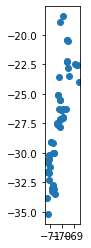

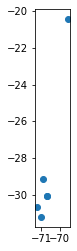

In [434]:
map_all.plot()
map_subset2.plot()

## Aggregated values

In [398]:
number_of_installations = selected_results3.index.size

6


In [414]:
sum_pv_reference_pre = (pv_reference[selected_results3.index].sum(axis=1).copy().to_frame())/number_of_installations
sum_pv_reference = sum_pv_reference_pre.where(sum_pv_reference_pre > 0.0, np.nan)
sum_pv_era5land = (pv_era5land[selected_results3.index].sum(axis=1).copy().to_frame())/number_of_installations
sum_pv_rn = (pv_rn[selected_results3.index].sum(axis=1).copy().to_frame())/number_of_installations

In [415]:
sum_pv_des_ref_pre = (des_ref[selected_results3.index].sum(axis=1).copy().to_frame())/number_of_installations
sum_pv_des_ref = sum_pv_des_ref_pre.where(sum_pv_reference_pre > 0.0, np.nan)
sum_pv_des_era5 = (des_era5[selected_results3.index].sum(axis=1).copy().to_frame())/number_of_installations
sum_pv_des_rn = (des_rn[selected_results3.index].sum(axis=1).copy().to_frame())/number_of_installations

In [417]:
#full_pv_set.loc[selected_results3.index]

In [419]:
start = "2016-02"
end = "2018-12-31"

#sum_pv_reference[start:end]
#sum_pv_era5land[start:end].plot()
#sum_pv_rn[start:end].plot()

In [420]:
#calculate the indicators for the raw aggregated data
start = "2016-02"
end = "2018"
csvname = "aggregated"

indicators = pd.DataFrame(columns=("pearson_h_era5","pearson_h_rn",
                                   "mbe_h_era5","mbe_h_rn",
                                   "rmse_h_era5","rmse_h_rn",
                                   "pearson_d_era5", "pearson_d_rn",
                                   "mbe_d_era5", "mbe_d_rn",
                                   "rmse_d_era5", "rmse_d_rn",
                                   "pearson_m_era5", "pearson_m_rn",
                                   "mbe_m_era5", "mbe_m_rn",
                                   "rmse_m_era5", "rmse_m_rn"), index= ["raw","deseasonalized"])
  
comp_pre = pd.DataFrame(columns=("era5","rn","reference"), index=rn.index)
comp_pre["rn"] = sum_pv_rn[start:end].copy()
comp_pre["era5"] = sum_pv_era5land[start:end].copy()
comp_pre["reference"] = sum_pv_reference[start:end].copy()
comp = comp_pre.dropna().copy()
rnin = comp["rn"]
era5 = comp["era5"]
reference = comp["reference"]
print(reference)
#print(reference.size)
#hourly indicators
pearson_rn = sp.stats.pearsonr(reference.astype(float), rnin.astype(float))
pearson_era5 = sp.stats.pearsonr(reference.astype(float), era5.astype(float))
indicators.loc["raw"]["pearson_h_rn"] = pearson_rn[0]
indicators.loc["raw"]["pearson_h_era5"] = pearson_era5[0]
indicators.loc["raw"]["mbe_h_rn"] = (np.sum(rnin-reference))/np.sum(reference.size)
indicators.loc["raw"]["mbe_h_era5"] = (np.sum(era5-reference))/np.sum(reference.size)
indicators.loc["raw"]["rmse_h_rn"] = np.sqrt((np.sum((rnin-reference)**2))/(reference.size))
indicators.loc["raw"]["rmse_h_era5"] = np.sqrt((np.sum((era5-reference)**2))/(reference.size))
#daily indicators
rn_avg_day = round(rnin.resample('D').mean(),4).dropna().copy()
era5_avg_day = round(era5.resample('D').mean(),4).dropna().copy()
reference_avg_day = round(reference.astype(float).resample('D').mean(),4).dropna().copy()
days = reference_avg_day.size
pearson_days_rn = sp.stats.pearsonr(reference_avg_day.astype(float), rn_avg_day.astype(float))
pearson_days_era5 = sp.stats.pearsonr(reference_avg_day.astype(float), era5_avg_day.astype(float))
indicators.loc["raw"]["pearson_d_era5"] = pearson_days_era5[0]
indicators.loc["raw"]["pearson_d_rn"] = pearson_days_rn[0]
indicators.loc["raw"]["mbe_d_era5"] = (np.sum(era5_avg_day-reference_avg_day))/days
indicators.loc["raw"]["mbe_d_rn"] = (np.sum(rn_avg_day-reference_avg_day))/days
indicators.loc["raw"]["rmse_d_era5"] = np.sqrt((np.sum((era5_avg_day-reference_avg_day)**2))/days)
indicators.loc["raw"]["rmse_d_rn"] = np.sqrt((np.sum((rn_avg_day-reference_avg_day)**2))/days)
#monthly indicators
rn_avg_month = round(rnin.resample('M').mean(),4).dropna().copy()
era5_avg_month = round(era5.resample('M').mean(),4).dropna().copy()
months = new_avg_month.size
reference_avg_month = round(reference.astype(float).resample('M').mean(),4).dropna().copy()
pearson_months_rn = sp.stats.pearsonr(reference_avg_month.astype(float), rn_avg_month.astype(float))
pearson_months_era5 = sp.stats.pearsonr(reference_avg_month.astype(float), era5_avg_month.astype(float))
indicators.loc["raw"]["pearson_m_rn"] = pearson_months_rn[0]
indicators.loc["raw"]["pearson_m_era5"] = pearson_months_era5[0]
indicators.loc["raw"]["mbe_m_rn"] = (np.sum(rn_avg_month-reference_avg_month))/months
indicators.loc["raw"]["rmse_m_rn"] = np.sqrt((np.sum((rn_avg_month-reference_avg_month)**2))/months)
indicators.loc["raw"]["mbe_m_era5"] = (np.sum(era5_avg_month-reference_avg_month))/months
indicators.loc["raw"]["rmse_m_era5"] = np.sqrt((np.sum((era5_avg_month-reference_avg_month)**2))/months)        


2016-02-01 10:00:00+00:00    0.003482
2016-02-01 11:00:00+00:00    0.096132
2016-02-01 12:00:00+00:00    0.336661
2016-02-01 13:00:00+00:00    0.557425
2016-02-01 14:00:00+00:00    0.734895
                               ...   
2018-12-31 19:00:00+00:00    0.651942
2018-12-31 20:00:00+00:00    0.479877
2018-12-31 21:00:00+00:00    0.271969
2018-12-31 22:00:00+00:00    0.087476
2018-12-31 23:00:00+00:00    0.006815
Name: reference, Length: 14149, dtype: float64


In [421]:
#calculate the indicators for the deseasonalized aggregated data
comp_pre = pd.DataFrame(columns=("era5","rn","reference"), index=rn.index)
comp_pre["rn"] = sum_pv_des_rn[start:end].copy()
comp_pre["era5"] = sum_pv_des_era5[start:end].copy()
comp_pre["reference"] = sum_pv_des_ref[start:end].copy()
comp = comp_pre.dropna().copy()
rnin = comp["rn"]
era5 = comp["era5"]
reference = comp["reference"]
print(reference)
#print(reference.size)
#hourly indicators
pearson_rn = sp.stats.pearsonr(reference.astype(float), rnin.astype(float))
pearson_era5 = sp.stats.pearsonr(reference.astype(float), era5.astype(float))
indicators.loc["deseasonalized"]["pearson_h_rn"] = pearson_rn[0]
indicators.loc["deseasonalized"]["pearson_h_era5"] = pearson_era5[0]
indicators.loc["deseasonalized"]["mbe_h_rn"] = (np.sum(rnin-reference))/np.sum(reference.size)
indicators.loc["deseasonalized"]["mbe_h_era5"] = (np.sum(era5-reference))/np.sum(reference.size)
indicators.loc["deseasonalized"]["rmse_h_rn"] = np.sqrt((np.sum((rnin-reference)**2))/(reference.size))
indicators.loc["deseasonalized"]["rmse_h_era5"] = np.sqrt((np.sum((era5-reference)**2))/(reference.size))
#daily indicators
rn_avg_day = round(rnin.resample('D').mean(),4).dropna().copy()
era5_avg_day = round(era5.resample('D').mean(),4).dropna().copy()
reference_avg_day = round(reference.astype(float).resample('D').mean(),4).dropna().copy()
days = reference_avg_day.size
pearson_days_rn = sp.stats.pearsonr(reference_avg_day.astype(float), rn_avg_day.astype(float))
pearson_days_era5 = sp.stats.pearsonr(reference_avg_day.astype(float), era5_avg_day.astype(float))
indicators.loc["deseasonalized"]["pearson_d_era5"] = pearson_days_era5[0]
indicators.loc["deseasonalized"]["pearson_d_rn"] = pearson_days_rn[0]
indicators.loc["deseasonalized"]["mbe_d_era5"] = (np.sum(era5_avg_day-reference_avg_day))/days
indicators.loc["deseasonalized"]["mbe_d_rn"] = (np.sum(rn_avg_day-reference_avg_day))/days
indicators.loc["deseasonalized"]["rmse_d_era5"] = np.sqrt((np.sum((era5_avg_day-reference_avg_day)**2))/days)
indicators.loc["deseasonalized"]["rmse_d_rn"] = np.sqrt((np.sum((rn_avg_day-reference_avg_day)**2))/days)
#monthly indicators
rn_avg_month = round(rnin.resample('M').mean(),4).dropna().copy()
era5_avg_month = round(era5.resample('M').mean(),4).dropna().copy()
months = new_avg_month.size
reference_avg_month = round(reference.astype(float).resample('M').mean(),4).dropna().copy()
pearson_months_rn = sp.stats.pearsonr(reference_avg_month.astype(float), rn_avg_month.astype(float))
pearson_months_era5 = sp.stats.pearsonr(reference_avg_month.astype(float), era5_avg_month.astype(float))
indicators.loc["deseasonalized"]["pearson_m_rn"] = pearson_months_rn[0]
indicators.loc["deseasonalized"]["pearson_m_era5"] = pearson_months_era5[0]
indicators.loc["deseasonalized"]["mbe_m_rn"] = (np.sum(rn_avg_month-reference_avg_month))/months
indicators.loc["deseasonalized"]["rmse_m_rn"] = np.sqrt((np.sum((rn_avg_month-reference_avg_month)**2))/months)
indicators.loc["deseasonalized"]["mbe_m_era5"] = (np.sum(era5_avg_month-reference_avg_month))/months
indicators.loc["deseasonalized"]["rmse_m_era5"] = np.sqrt((np.sum((era5_avg_month-reference_avg_month)**2))/months)        
indicators.to_csv(str("indicators_" + csvname + ".csv"))  

2016-02-01 10:00:00+00:00    0.003482
2016-02-01 11:00:00+00:00   -0.006745
2016-02-01 12:00:00+00:00    0.014275
2016-02-01 13:00:00+00:00    0.020858
2016-02-01 14:00:00+00:00    0.013578
                               ...   
2018-12-31 19:00:00+00:00   -0.201778
2018-12-31 20:00:00+00:00   -0.223277
2018-12-31 21:00:00+00:00   -0.241815
2018-12-31 22:00:00+00:00   -0.213047
2018-12-31 23:00:00+00:00   -0.083871
Name: reference, Length: 14149, dtype: float64


In [422]:
#this table was manually formated to be included in the paper see file tables.xlsx
indicators.T

,raw,deseasonalized
pearson_h_era5,0.970486,0.88008
pearson_h_rn,0.964958,0.838791
mbe_h_era5,0.0178699,0.00707177
mbe_h_rn,0.0473539,0.0365558
rmse_h_era5,0.0823015,0.0734366
rmse_h_rn,0.09728,0.0849421
pearson_d_era5,0.860135,0.939175
pearson_d_rn,0.784735,0.894859
mbe_d_era5,0.0191929,0.00856854
mbe_d_rn,0.0487978,0.0381762


### table with average results for all indicators and subsets in the R code